In [1]:
# Data manipulation
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Dimensionality Reduction
from sklearn.manifold import TSNE

In [2]:
# Import dataset from datasets directory
ansur = pd.read_csv('~/DevSpace/Data-Snippets/MachineLearning/datasets/ansur.csv')
ansur.head()

,Gender,weight_kg,stature_m,body_height
0,Male,81.5,1.776,69.92
1,Male,72.6,1.702,67.01
2,Male,92.9,1.735,68.31
3,Male,79.4,1.655,65.16
4,Male,94.6,1.914,75.35


In [3]:
# Spot perfect correlation in data
ansur.corr()

,weight_kg,stature_m,body_height
weight_kg,1.000000,0.610908,0.610888
stature_m,0.610908,1.000000,1.000000
body_height,0.610888,1.000000,1.000000


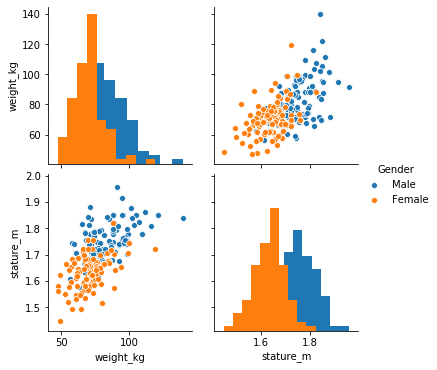

In [4]:
# Remove perfectly correlated columns as they provide redundant information
ansur = ansur.drop('body_height', axis=1)

# Check visualization
sns.pairplot(ansur, hue='Gender', diag_kind='hist')
plt.show()

In [5]:
# High dimensional data import
body_dims = pd.read_csv('~/DevSpace/Data-Snippets/MachineLearning/datasets/body_measurements.csv')
body_dims.head()

,ID,Branch,Component,Gender,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,...,trochanterionheight,verticaltrunkcircumferenceusa,waistbacklength,waistbreadth,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,wristcircumference,wristheight
0,38,Combat Service Support,Regular Army,Male,204,1412,339,218,1307,241,...,912,1632,456,271,790,202,367,1045,172,821
1,2401,Combat Service Support,Army National Guard,Male,344,1408,336,252,1290,253,...,899,1779,470,378,1200,331,385,1014,198,840
2,3819,Combat Support,Army National Guard,Male,251,1393,324,205,1284,236,...,868,1617,494,336,957,245,392,1018,160,823
3,81,Combat Service Support,Regular Army,Male,225,1392,341,226,1301,254,...,931,1610,436,305,892,227,372,1065,178,793
4,464,Combat Service Support,Army National Guard,Female,207,1431,336,214,1321,237,...,895,1626,419,283,800,179,344,1060,162,802


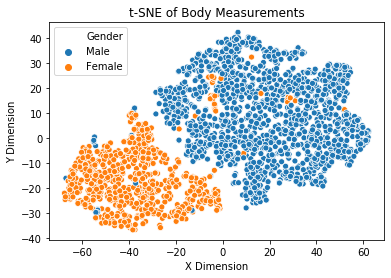

In [6]:
# Instanciate TSNE Model
tsne_model = TSNE(learning_rate=50)

# Fit and transform data 
tsne_features = tsne_model.fit_transform(body_dims.iloc[:, 4:])

# Add components to df
body_dims['x'] = tsne_features[:, 0]
body_dims['y'] = tsne_features[:, 1]

# Plot transformed data
sns.scatterplot(x='x', y='y', hue='Gender', data=body_dims)
plt.xlabel('X Dimension')
plt.ylabel('Y Dimension')
plt.title('t-SNE of Body Measurements')
plt.show()